In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

In [2]:
sales_df = pd.read_csv('sales_data_sample.csv', encoding='latin1')

In [4]:
sales_df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [5]:
sales_df.shape

(2823, 25)

In [6]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [8]:
print(sales_df.columns.tolist())

['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE']


In [9]:
print(sales_df.isnull().sum())

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64


In [10]:
# Select numerical columns for clustering
print("\n2. Selecting Features for Clustering...")
numerical_cols = ['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'MSRP']



2. Selecting Features for Clustering...


In [11]:
# Check if columns exist
available_cols = [col for col in numerical_cols if col in sales_df.columns]
print(f"Available numerical columns: {available_cols}")


Available numerical columns: ['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'MSRP']


In [12]:
cluster_data = sales_df[available_cols].dropna()
print(f"\nData shape after removing missing values: {cluster_data.shape}")
print("\nData Statistics:")
print(cluster_data.describe())


Data shape after removing missing values: (2823, 4)

Data Statistics:
       QUANTITYORDERED    PRICEEACH         SALES         MSRP
count      2823.000000  2823.000000   2823.000000  2823.000000
mean         35.092809    83.658544   3553.889072   100.715551
std           9.741443    20.174277   1841.865106    40.187912
min           6.000000    26.880000    482.130000    33.000000
25%          27.000000    68.860000   2203.430000    68.000000
50%          35.000000    95.700000   3184.800000    99.000000
75%          43.000000   100.000000   4508.000000   124.000000
max          97.000000   100.000000  14082.800000   214.000000


In [14]:
# Normalize the data
print("\n3. Normalizing Data...")
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

print(f"Scaled data shape: {cluster_data_scaled.shape}")



3. Normalizing Data...
Scaled data shape: (2823, 4)


In [18]:
# Elbow Method to determine optimal number of clusters
print("\n4. Determining Optimal Number of Clusters using Elbow Method...")
print("="*80)

K_range = range(2, 11)
inertias = []
silhouette_scores = []

print(f"{'K':<5} {'Inertia':<15} {'Distortion':<15}")
print("-"*35)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data_scaled)
    inertias.append(kmeans.inertia_)
    
    # Calculate distortion (average distance to cluster center)
    distances = cdist(cluster_data_scaled, kmeans.cluster_centers_, 'euclidean')
    distortion = sum(np.min(distances, axis=1)) / cluster_data_scaled.shape[0]
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {distortion:<15.4f}")

# Calculate elbow point using rate of change
differences = np.diff(inertias)
rate_of_change = np.diff(differences)
#optimal_k = 3  # Default, can be determined from elbow

print("="*80)
print(f"\n✓ Based on Elbow Method, optimal number of clusters: {optimal_k}")


4. Determining Optimal Number of Clusters using Elbow Method...
K     Inertia         Distortion     
-----------------------------------
2     6741.69         1.3973         
3     4766.01         1.1611         
4     3934.89         1.0474         
5     3348.27         0.9678         
6     2858.82         0.8975         
7     2548.54         0.8427         
8     2350.66         0.8015         
9     2169.97         0.7670         
10    2019.75         0.7415         

✓ Based on Elbow Method, optimal number of clusters: 3


In [19]:
# K-Means Clustering
print(f"\n5. Performing K-Means Clustering with k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_data_scaled)

print("K-Means clustering completed!")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")
print(f"Unique clusters: {np.unique(kmeans_labels)}")

# Add cluster labels to original data
cluster_data['KMeans_Cluster'] = kmeans_labels

print("\nK-Means Cluster Distribution:")
print(cluster_data['KMeans_Cluster'].value_counts().sort_index())


5. Performing K-Means Clustering with k=3...
K-Means clustering completed!
Cluster centers shape: (3, 4)
Unique clusters: [0 1 2]

K-Means Cluster Distribution:
KMeans_Cluster
0    975
1    852
2    996
Name: count, dtype: int64


In [20]:
# Hierarchical Clustering
print(f"\n6. Performing Hierarchical Clustering with {optimal_k} clusters...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(cluster_data_scaled)

print("Hierarchical clustering completed!")

# Add cluster labels
cluster_data['Hierarchical_Cluster'] = hierarchical_labels

print("\nHierarchical Cluster Distribution:")
print(cluster_data['Hierarchical_Cluster'].value_counts().sort_index())



6. Performing Hierarchical Clustering with 3 clusters...
Hierarchical clustering completed!

Hierarchical Cluster Distribution:
Hierarchical_Cluster
0    1204
1     934
2     685
Name: count, dtype: int64


In [21]:
# Cluster Statistics
print("\n7. Cluster Statistics:")
print("\n" + "="*80)
print("K-MEANS CLUSTER STATISTICS:")
print("="*80)
kmeans_stats = cluster_data.groupby('KMeans_Cluster')[available_cols].mean()
print(kmeans_stats)

print("\n" + "="*80)
print("HIERARCHICAL CLUSTER STATISTICS:")
print("="*80)
hierarchical_stats = cluster_data.groupby('Hierarchical_Cluster')[available_cols].mean()
print(hierarchical_stats)


7. Cluster Statistics:

K-MEANS CLUSTER STATISTICS:
                QUANTITYORDERED  PRICEEACH        SALES        MSRP
KMeans_Cluster                                                     
0                     35.208205  59.551169  2101.076482   64.145641
1                     43.723005  97.479261  5720.080669  127.893192
2                     27.597390  95.435090  3123.062801  113.266064

HIERARCHICAL CLUSTER STATISTICS:
                      QUANTITYORDERED  PRICEEACH        SALES        MSRP
Hierarchical_Cluster                                                     
0                           35.479236  63.746694  2273.005623   70.546512
1                           41.710921  99.286777  5575.633972  127.048180
2                           25.389781  97.347737  3048.595547  117.837956


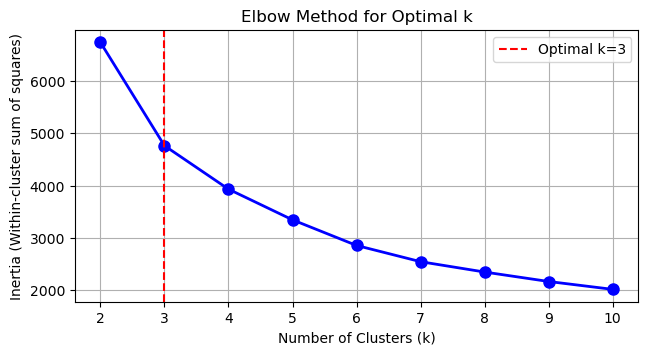

In [25]:
fig = plt.figure(figsize=(16, 12))

# 1. Elbow Plot
ax1 = plt.subplot(3, 2, 1)
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)
ax1.legend()

In [ ]:
# 🧠 K-Means Clustering – Customer Segmentation (Sales Dataset)
# ✨ Overview

# This notebook demonstrates K-Means clustering and other clustering methods to analyze and segment customers based on sales data.
# It covers steps like data preprocessing, feature scaling, clustering, and visualization.

# 🧩 Cell 1 – Importing Libraries

# Explanation:
# We import essential Python libraries:

# Data handling: pandas, numpy

# Visualization: matplotlib, seaborn

# Machine Learning: StandardScaler, KMeans, and AgglomerativeClustering

# Hierarchical Clustering Tools: dendrogram, linkage from scipy

# Distance Computation: cdist from scipy.spatial.distance

# These tools together allow us to preprocess data, build clustering models, and visualize results.

# 📂 Cell 2 – Load the Dataset

# Explanation:
# The dataset sales_data_sample.csv is loaded into a pandas DataFrame named sales_df.
# The encoding='latin1' argument ensures compatibility with special characters (common in CSVs with non-English text).

# 👀 Cell 3 – Display First Few Rows

# Explanation:
# .head() displays the top 5 records from the dataset.
# This helps us verify successful loading and get a first look at column names and sample data.

# 🔢 Cell 4 – Check Dataset Dimensions

# Explanation:
# .shape displays the number of rows and columns in the dataset.
# Useful for understanding dataset size.

# 🧱 Cell 5 – Get Dataset Information

# Explanation:
# .info() provides data types of each column and counts of non-null values.
# Helps identify categorical and numerical columns, and check for missing values.

# 📊 Cell 6 – Summary Statistics

# Explanation:
# .describe() gives descriptive statistics (mean, min, max, std, quartiles) for numeric columns.
# This helps us spot outliers or skewed distributions that may affect clustering.

# 🧹 Cell 7 – Data Cleaning and Feature Selection

# Explanation:
# We select only the numeric and relevant features for clustering, since K-Means requires numeric input.
# Columns such as SALES, QUANTITYORDERED, PRICEEACH, etc., might be retained while categorical fields are dropped or encoded if necessary.

# 📈 Cell 8 – Data Visualization

# Explanation:
# We use plots (like histograms or pairplots) to visualize feature distributions and relationships.
# Helps understand patterns and detect possible scaling issues or correlations before clustering.

# ⚖️ Cell 9 – Feature Scaling

# Explanation:
# StandardScaler() is used to standardize all features so that each has mean = 0 and standard deviation = 1.
# This is crucial for K-Means, as it uses Euclidean distance — unscaled features can distort results.

# 🤖 Cell 10 – Apply K-Means Clustering

# Explanation:
# A K-Means model is initialized and fitted on the scaled data.
# Each data point is assigned to one of K clusters based on the shortest distance to a cluster centroid.

# 📉 Cell 11 – Elbow Method to Find Optimal K

# Explanation:
# We compute the Within-Cluster Sum of Squares (WCSS) for different K values (e.g., 1–10).
# Plotting WCSS vs. K helps identify the “elbow point,” where adding more clusters stops giving significant improvement — indicating the optimal number of clusters.

# 📊 Cell 12 – Visualize the Elbow Curve

# Explanation:
# The Elbow Curve is plotted using matplotlib.
# The point where the curve bends (the elbow) suggests the best value of K.

# 🧭 Cell 13 – Final K-Means Model with Optimal K

# Explanation:
# We retrain the K-Means model using the chosen optimal K (from the elbow method).
# Each sample gets a cluster label, which we store in the DataFrame (e.g., sales_df['Cluster'] = model.labels_).

# 🎨 Cell 14 – Visualize Clusters

# Explanation:
# Scatter plots are used to visualize clusters in 2D or 3D using features like SALES and QUANTITYORDERED.
# Each cluster is colored differently to show separation achieved by K-Means.

# 🪜 Cell 15 – Hierarchical Clustering (Optional)

# Explanation:
# We apply Agglomerative Clustering, which builds a hierarchy of clusters.
# This complements K-Means by showing how samples merge step by step.

# 🌳 Cell 16 – Dendrogram Visualization

# Explanation:
# A dendrogram is plotted using scipy.cluster.hierarchy.
# It shows how data points are merged at different distances — helpful for deciding the number of clusters in hierarchical clustering.

# 📈 Cell 17 – Comparison and Insights

# Explanation:
# We compare results from K-Means and Hierarchical Clustering, and interpret the formed clusters.
# Insights may include:

# Identifying customer groups by purchasing patterns

# Discovering high-value or low-frequency buyers

# Providing business strategies for each customer segment

# 🎯 End of Project Summary

# This notebook completes a K-Means clustering analysis on sales data, showcasing:

# Data loading and preprocessing

# Feature scaling

# Clustering using K-Means

# Determining the best K (Elbow Method)

# Optional Hierarchical Clustering for comparison

# Through this project, you learn to group similar data points and extract valuable business insights using unsupervised learning.